## Fine tuning Alexnet to predict neural activity

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pickle

In [ ]:
datapath = 'dataset/nsd_subj01_roi_wise_betas.pkl'
with open(datapath, 'rb') as f:
    data = pickle.load(f)

# Check keys
print(data.keys())

dict_keys(['faces', 'bodies', 'places', 'words', 'evc'])


In [5]:
response = np.stack(np.array(data['bodies']['avg_betas']))
# randomly select 1000 voxels
# np.random.seed(42)
# voxels = np.random.choice(response.shape[1], 1000, replace=False)
# response = response[:, voxels]
response.shape

(10000, 3797)

In [6]:
# load coco imags
cocopath = 'dataset/subj01_unique_stim_dict.pkl'
with open(cocopath, 'rb') as f:
    imagedata = pickle.load(f)
# Check keys
print(imagedata.keys())
print(imagedata['nsd_img'].shape)  # Display first 10 categories

dict_keys(['nsd_id', 'nsd_img', 'coco_super_cat'])
(9000, 425, 425, 3)


In [7]:
cocopath = 'dataset/df_super_cat_dict.pkl'
with open(cocopath, 'rb') as f:
    supercat = pickle.load(f)
# Check keys
print(len(supercat))

9000


In [8]:
import numpy as np
import ast
from collections import Counter
flat_list = np.hstack(supercat)
# Step 3: Count frequencies
counts = Counter(flat_list)
# sort by count
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
for category, count in sorted_counts:
    print(f"{category}: {count}")

person: 4636
vehicle: 2897
furniture: 2860
kitchen: 2789
sports: 2324
animal: 2071
accessory: 1600
food: 1472
indoor: 1314
electronic: 1255
outdoor: 1026
appliance: 934


In [9]:
class_labels = list(set(flat_list))
print(class_labels)

['animal', 'sports', 'vehicle', 'accessory', 'furniture', 'food', 'appliance', 'kitchen', 'outdoor', 'electronic', 'person', 'indoor']


In [10]:
stim_ids = np.array(data['bodies']['stim_id'])       # shape (10000,)
nsd_ids  = np.array(imagedata['nsd_id'])            # shape (9000,)
# Create a boolean mask of where stim_ids match nsd_ids
mask = np.isin(stim_ids, nsd_ids)
# Get the indices in stim_ids that match nsd_ids
matching_indices = np.where(mask)[0]
assert(nsd_ids == stim_ids[matching_indices]).all()  # Check that the match is correct

In [11]:
voxels = response[matching_indices]
images = imagedata['nsd_img']
labels = supercat  # list of label lists, one per image
class_names = class_labels  # the fixed set of target categories
label_vectors = []
for label_ in labels:
    label_vector = np.zeros(len(class_names))
    for label in label_:
        if label in class_names:
            label_vector[class_names.index(label)] = 1.0
    label_vectors.append(label_vector)
label_vectors = np.stack(label_vectors) 
print(voxels.shape)
print(images.shape)
print(label_vectors.shape)


(9000, 3797)
(9000, 425, 425, 3)
(9000, 12)


In [12]:
np.mean(label_vectors, axis=0)  # Check mean of each class label vector

array([0.21488889, 0.20555556, 0.23033333, 0.14233333, 0.23566667,
       0.13266667, 0.07033333, 0.16755556, 0.10655556, 0.09322222,
       0.51511111, 0.12922222])

In [13]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

images_train, images_test, voxels_train, voxels_test, labels_train, labels_test = train_test_split(
    images, voxels, label_vectors, test_size=0.2, random_state=42, shuffle=True
)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def to_pil_image(img):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    img = np.squeeze(img)  # remove single channel if (1, H, W)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    return Image.fromarray(img)

class MultiLabelDataset(Dataset):
    def __init__(self, images, voxels, labels, transform=None):
        self.images = images
        self.voxels = voxels
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = to_pil_image(self.images[idx])
        if self.transform:
            image = self.transform(image)

        voxel = torch.tensor(self.voxels[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, voxel, label

train_dataset = MultiLabelDataset(images_train, voxels_train, labels_train, transform=transform)
test_dataset  = MultiLabelDataset(images_test, voxels_test, labels_test, transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,       # adjust based on CPU
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [14]:
for im, vo, la in train_loader:
    print("Batch of images shape:", im.shape)
    print("Batch of voxels shape:", vo.shape)
    print("Batch of labels shape:", la.shape)
    break  # just to check the first batch

Batch of images shape: torch.Size([128, 3, 224, 224])
Batch of voxels shape: torch.Size([128, 3797])
Batch of labels shape: torch.Size([128, 12])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

# --- Configuration ---
n_epochs = 200
warmup_epochs = 200
learning_rate = 0.0001
lambda_vox = 0.3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = la.shape[1]  # from labels
_, voxels, _ = next(iter(train_loader))
num_voxels = voxels.size(1)
test_loss_voxel = []
test_loss_cls = []
# --- Model Definition ---
class AlexNetWithVoxelPrediction(nn.Module):
    def __init__(self, voxel_dim, num_classes):
        super(AlexNetWithVoxelPrediction, self).__init__()
        base_model = models.alexnet(pretrained=True)

        # Unfreeze all layers
        for param in base_model.parameters():
            param.requires_grad = True

        self.features = base_model.features
        self.avgpool = base_model.avgpool

        conv_output_dim = 256 * 6 * 6  # = 9216

        self.fc1 = nn.Sequential(
            nn.Linear(conv_output_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )

        # Classifier for labels
        self.classifier = nn.Linear(4096, num_classes)

        # Decoder for voxel prediction
        self.voxel_decoder = nn.Sequential(
            nn.Linear(conv_output_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, voxel_dim)
        )

    def forward(self, images):
        x = self.features(images)
        x = self.avgpool(x)
        conv5 = torch.flatten(x, 1)
        x = self.fc1(conv5)
        x = self.fc2(x)  # also known as fc7 in AlexNet
        logits = self.classifier(x)
        voxel_pred = self.voxel_decoder(conv5)
        return logits, voxel_pred

# --- Instantiate model, optimizer, loss functions ---
model = AlexNetWithVoxelPrediction(voxel_dim=num_voxels, num_classes=num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

classification_loss = nn.BCEWithLogitsLoss()
voxel_loss = nn.MSELoss()

# --- Track Losses ---
train_loss, test_loss = np.zeros(n_epochs), np.zeros(n_epochs)

# --- Training Loop ---
for epoch in range(n_epochs):
    #lambda_vox = max(0.0, 1.0 - epoch / warmup_epochs)
    model.train()
    for images, voxels, labels in train_loader:
        images = images.to(device, non_blocking=True)
        voxels = voxels.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits, voxel_pred = model(images)
        loss_cls = classification_loss(logits, labels)
        loss_vox = voxel_loss(voxel_pred, voxels)
        
        loss = lambda_vox * loss_vox + (1 - lambda_vox) * loss_cls
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()

    train_loss[epoch] /= len(train_loader)

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        for images, voxels, labels in test_loader:
            images = images.to(device)
            voxels = voxels.to(device)
            labels = labels.to(device)
            logits, voxel_pred = model(images)
            loss_cls = classification_loss(logits, labels)
            loss_vox = voxel_loss(voxel_pred, voxels)
            loss = loss_cls + loss_vox
            test_loss[epoch] += loss.item()

    test_loss[epoch] /= len(test_loader)
    test_loss_voxel.append(loss_vox.item())
    test_loss_cls.append(loss_cls.item())
    print(f"Epoch {epoch+1}: Train Loss = {train_loss[epoch]:.4f}, Test Loss = {test_loss[epoch]:.4f}")
    print(f"voxel loss {loss_vox.item()}, classification loss {loss_cls.item()}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 251MB/s] 


Epoch 1: Train Loss = 0.6698, Test Loss = 1.2326
voxel loss 0.6446219086647034, classification loss 0.5880143046379089
Epoch 2: Train Loss = 0.5908, Test Loss = 1.1540
voxel loss 0.6238712072372437, classification loss 0.5301685929298401
Epoch 3: Train Loss = 0.5539, Test Loss = 1.1106
voxel loss 0.6092642545700073, classification loss 0.5013002157211304
Epoch 4: Train Loss = 0.5344, Test Loss = 1.0821
voxel loss 0.5969395041465759, classification loss 0.4852043390274048
Epoch 5: Train Loss = 0.5222, Test Loss = 1.0613
voxel loss 0.5859326720237732, classification loss 0.4753473103046417
Epoch 6: Train Loss = 0.5128, Test Loss = 1.0449
voxel loss 0.5760408043861389, classification loss 0.46887505054473877
Epoch 7: Train Loss = 0.5057, Test Loss = 1.0315
voxel loss 0.5673280358314514, classification loss 0.46420517563819885
Epoch 8: Train Loss = 0.4999, Test Loss = 1.0202
voxel loss 0.5596363544464111, classification loss 0.4606131613254547
Epoch 9: Train Loss = 0.4954, Test Loss = 1.01

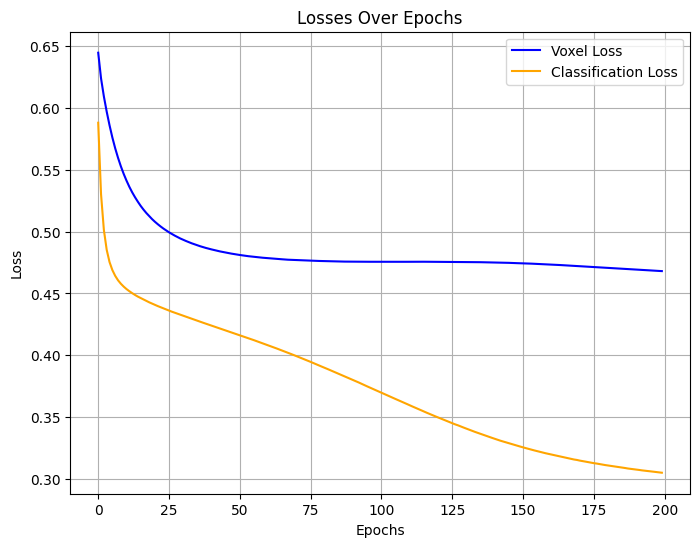

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(test_loss_voxel, label='Voxel Loss', color='blue')
plt.plot(test_loss_cls, label='Classification Loss', color='orange')
plt.title('Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, voxels, labels in test_loader:
        images = images.to(device)
        voxels = voxels.to(device)
        labels = labels.to(device)

        outputs,_ = model(images)
        probs = torch.sigmoid(outputs)

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Stack predictions and targets
all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Binarize predictions at 0.5 threshold
preds = (all_probs > 0.5).astype(float)

# Accuracy per class
class_accuracy = np.mean(preds == all_labels, axis=0)

# AUROC per class
auroc_scores = []
for i in range(all_labels.shape[1]):
    try:
        auroc = roc_auc_score(all_labels[:, i], all_probs[:, i])
    except ValueError:
        auroc = float('nan')  # Not defined when only one class present
    auroc_scores.append(auroc)

# F1 Score per class
f1_scores = f1_score(all_labels, preds, average=None)

# Print metrics
print(f"{'Label':<10} | {'Accuracy':>8} | {'AUROC':>6} | {'F1':>6}")
print("-" * 36)
for i, label in enumerate(class_labels):
    print(f"{label:<10} | {class_accuracy[i]:8.4f} | {auroc_scores[i]:6.4f} | {f1_scores[i]:6.4f}")

Label      | Accuracy |  AUROC |     F1
------------------------------------
animal     |   0.8939 | 0.8838 | 0.7066
sports     |   0.8867 | 0.9186 | 0.6973
vehicle    |   0.8533 | 0.8899 | 0.6708
accessory  |   0.8628 | 0.7738 | 0.1394
furniture  |   0.8206 | 0.8475 | 0.6075
food       |   0.9267 | 0.9343 | 0.6959
appliance  |   0.9511 | 0.9369 | 0.4568
kitchen    |   0.8506 | 0.8735 | 0.4972
outdoor    |   0.8700 | 0.8041 | 0.0000
electronic |   0.9172 | 0.8353 | 0.0000
person     |   0.7850 | 0.8807 | 0.7837
indoor     |   0.8717 | 0.7861 | 0.0870


In [18]:
torch.save(model.state_dict(), "alexnet_w_voxel_2_places.pth")
# save training and test losses
np.savez("losses_2_places.npz", train_loss=train_loss, test_loss=test_loss, class_names=class_labels,class_accuracy=class_accuracy,
         auroc_scores=auroc_scores, f1_scores=f1_scores)